# Notebook to construct training data using snow cover stats from ELA CSVs and terrain parameters from RGI outlines

Note: You should decide what to do with your adjusted ELAs. Do we use those in place of the automated ELAs in the training data?

In [ ]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import geopandas as gpd

In [ ]:
# If using Google Colab, mount Google Drive so you can access the files in this folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Define path in directory to `study-sites`

In [ ]:
## Alexandra's path to study-sites/
study_sites_path = ('/content/drive/My Drive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/')

# Rainey's path to study-sites/
#study_sites_path = 'drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'

# define output settings for training data CSV
out_path = os.path.join(study_sites_path, '..', 'snow-cover-mapping-application', 'inputs-outputs')
out_fn = 'ELA_training_data.csv'

## Grab list of all sites with ELA CSVs from `study_sites_path`

In [ ]:
# Grab all site names in study_site_path
site_names = sorted(os.listdir(study_sites_path))
# Only include site names with ELA CSVs
site_names = [site_name for site_name in site_names if
              len(glob.glob(os.path.join(study_sites_path, site_name, 'ELAs', '*.csv')))>0]
print('Number of sites with ELA CSVs in file = ', len(site_names))
site_names

Number of sites with ELA CSVs in file =  95


['Blue',
 'Boulder',
 'Carbon',
 'Coleman',
 'Easton',
 'Gulkana',
 'LemonCreek',
 'RGI60-01.00037',
 'RGI60-01.00038',
 'RGI60-01.00312',
 'RGI60-01.01151',
 'RGI60-01.01524',
 'RGI60-01.01733',
 'RGI60-01.08246',
 'RGI60-01.08248',
 'RGI60-01.08288',
 'RGI60-01.08296',
 'RGI60-01.10778',
 'RGI60-01.11616',
 'RGI60-01.11654',
 'RGI60-01.11788',
 'RGI60-01.12370',
 'RGI60-01.14523',
 'RGI60-01.16262',
 'RGI60-01.17464',
 'RGI60-01.17761',
 'RGI60-01.17774',
 'RGI60-01.17803',
 'RGI60-01.17807',
 'RGI60-01.19460',
 'RGI60-01.19592',
 'RGI60-01.19599',
 'RGI60-01.19682',
 'RGI60-01.19725',
 'RGI60-01.19773',
 'RGI60-01.19814',
 'RGI60-01.19825',
 'RGI60-01.20180',
 'RGI60-01.20181',
 'RGI60-01.20186',
 'RGI60-01.20196',
 'RGI60-01.20272',
 'RGI60-01.20274',
 'RGI60-01.20279',
 'RGI60-01.20286',
 'RGI60-01.20302',
 'RGI60-01.20303',
 'RGI60-01.20309',
 'RGI60-01.20324',
 'RGI60-01.20796',
 'RGI60-01.21014',
 'RGI60-01.22699',
 'RGI60-01.23597',
 'RGI60-01.23635',
 'RGI60-01.23649',
 'RGI6

## Loop through `site_names`, load ELA CSVs and RGI outlines, compile into training data

In [ ]:
# Initialize data frame for training data
training_data = pd.DataFrame()

for site_name in (site_names):

    # Load ELAs
    elas = pd.DataFrame() # initialize data frame for ELAs
    ela_fns = glob.glob(os.path.join(study_sites_path, site_name, 'ELAs', '*.csv'))
    # loop over ELA file names
    for ela_fn in ela_fns:
        ela = pd.read_csv(ela_fn) # read ELA file
        elas = pd.concat([elas, ela]) # concatenate to full elas dataframe
    elas.reset_index(drop=True, inplace=True) # renumber dataframe index

    # Load RGI outline
    if 'RGI' in site_name:
        rgi_fn = os.path.join(study_sites_path, site_name, 'AOIs', site_name + '_outline.shp')
    else:
        rgi_fn = os.path.join(study_sites_path, site_name, 'AOIs', site_name + '_RGI_outline.shp')
    rgi = gpd.read_file(rgi_fn)

    # Add RGI terrain parameters to elas
    rgi['glacier_outline'] = rgi['geometry']
    columns = ['CenLon', 'CenLat', 'O1Region', 'O2Region', 'Area',
               'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 'Status',
               'Connect', 'Form', 'TermType', 'Surging', 'glacier_outline']
    elas[columns] = [rgi[column][0] for column in columns]

    # Add all to training data frame
    training_data = pd.concat([training_data, elas])

# Save training data to file
training_data.to_csv(os.path.join(out_path, out_fn), index=False)
print('Training data saved to file: ', os.path.join(out_path, out_fn))
training_data.reset_index(drop=True, inplace=True) # renumber training data index
training_data


Training data saved to file:  /content/drive/My Drive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/inputs-outputs/ELA_training_data.csv


,site_name,datetime,snowlines_coords_X,snowlines_coords_Y,CRS,snowline_elevs_m,snowline_elevs_median_m,SCA_m2,AAR,dataset,...,Status,Connect,Form,TermType,Surging,glacier_outline,ELA_from_AAR_m,HorizontalCRS,VerticalCRS,study_site
0,Blue,2016-07-25 13:08:00,"[449085.0, 449085.0, 449085.0, 449100.0, 44907...","[5296110.0, 5296080.0, 5296050.0, 5296035.0, 5...",EPSG:32610,"[1576.050464583104, 1577.6071934074635, 1582.1...",1600.6852,3264300.0,0.691779,Landsat,...,0,0,0,0,0,POLYGON ((-123.69207798899998 47.8272871070000...,NaN,NaN,NaN,NaN
1,Blue,2017-08-04 13:16:50,"[448925.0, 448920.0, 448915.0, 448905.0, 44890...","[5296790.0, 5296795.0, 5296800.0, 5296800.0, 5...",EPSG:32610,"[1485.7038112698187, 1485.7038112698187, 1485....",1583.6935,4264800.0,0.753978,Sentinel-2_TOA,...,0,0,0,0,0,POLYGON ((-123.69207798899998 47.8272871070000...,NaN,NaN,NaN,NaN
2,Blue,2018-08-14 13:15:14,"[449085.0, 449080.0, 449080.0, 449080.0, 44908...","[5296280.0, 5296275.0, 5296265.0, 5296255.0, 5...",EPSG:32610,"[1563.236634969104, 1565.2014556949357, 1567.2...",1697.4800,3040000.0,0.595366,Sentinel-2_TOA,...,0,0,0,0,0,POLYGON ((-123.69207798899998 47.8272871070000...,NaN,NaN,NaN,NaN
3,Blue,2019-08-19 13:21:18,"[449165.0, 449160.0, 449160.0, 449165.0, 44912...","[5295760.0, 5295755.0, 5295745.0, 5295740.0, 5...",EPSG:32610,"[1624.287685046157, 1625.7230862123972, 1625.7...",1783.7914,2966500.0,0.524450,Sentinel-2_SR,...,0,0,0,0,0,POLYGON ((-123.69207798899998 47.8272871070000...,NaN,NaN,NaN,NaN
4,Blue,2020-10-02 13:21:16,"[449125.0, 449120.0, 449120.0, 449115.0, 44911...","[5295460.0, 5295455.0, 5295445.0, 5295440.0, 5...",EPSG:32610,"[1685.1254269537037, 1688.9502624544664, 1692....",1976.4092,2455900.0,0.434181,Sentinel-2_SR,...,0,0,0,0,0,POLYGON ((-123.69207798899998 47.8272871070000...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,SouthCascade,2020-07-26 13:11:14,"[643715.0, 643710.0, 643710.0, 643705.0, 64370...","[5358250.0, 5358255.0, 5358265.0, 5358270.0, 5...",EPSG:32610,"[1764.0, 1764.0, 1765.0, 1765.0, 1765.0, 1763....",1747.0000,1746500.0,0.970008,Sentinel-2_TOA,...,0,0,0,0,0,POLYGON ((-121.07246183899997 48.3568376590000...,NaN,NaN,NaN,NaN
789,SouthCascade,2021-07-26 18:00:00,"[643743.0, 643741.5, 643740.0, 643740.0, 64373...","[5358382.5, 5358381.0, 5358379.5, 5358376.5, 5...",EPSG:32610,"[1744.0, 1743.0, 1743.0, 1744.0, 1743.0, 1743....",1765.0000,1610883.0,0.903145,PlanetScope,...,0,0,0,0,0,POLYGON ((-121.07246183899997 48.3568376590000...,NaN,NaN,NaN,NaN
790,SouthCascade,2022-07-29 13:21:14,"[644100.0, 644095.0, 644090.0, 644085.0, 64408...","[5358205.0, 5358200.0, 5358205.0, 5358210.0, 5...",EPSG:32610,"[1762.0, 1763.0, 1763.0, 1760.0, 1760.0, 1758....",1768.0000,1701000.0,0.944738,Sentinel-2_SR,...,0,0,0,0,0,POLYGON ((-121.07246183899997 48.3568376590000...,NaN,NaN,NaN,NaN
791,Wolverine,2021-08-29 15:18:32,"[393515.0, 393510.0, 393505.0, 393500.0, 39349...","[6698580.0, 6698585.0, 6698590.0, 6698585.0, 6...",EPSG:32606,"[1242.0, 1242.0, 1244.0, 1244.0, 1246.0, 1283....",1256.5000,8578800.0,0.557412,Sentinel-2_SR,...,0,0,0,0,9,POLYGON ((-148.93629700399998 60.4085156910000...,NaN,NaN,NaN,NaN


## Make some plots for fun

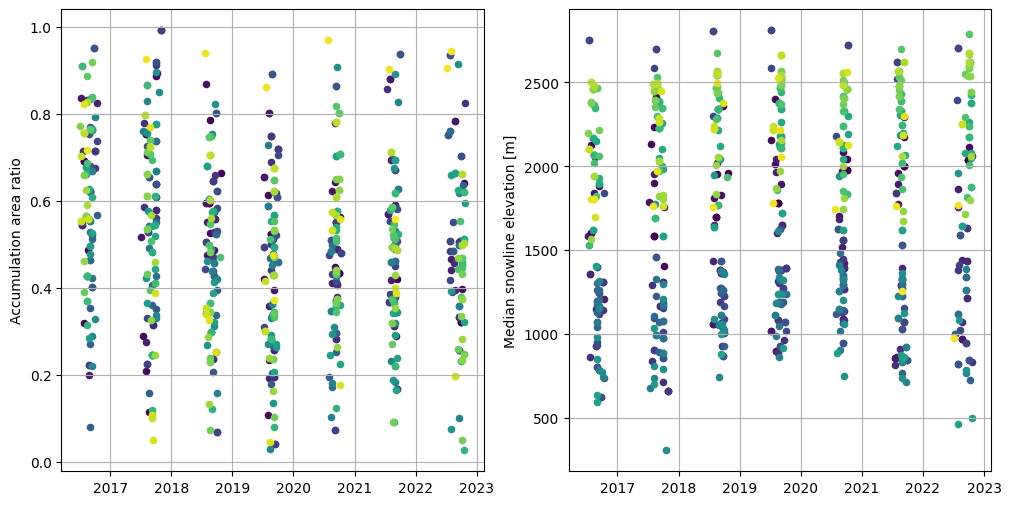

In [ ]:
from matplotlib.backend_bases import GraphicsContextBase
# -----Plot ELAs for all sites
# pick a colormap
cmap=plt.cm.viridis
# convert datetime strings to pandas datetimes
training_data['datetime'] = pd.to_datetime(training_data['datetime'])
# set datetime as index
training_data.index = training_data['datetime']

# plot
fig, ax = plt.subplots(1,2, figsize=(12,6))
nsites = len(training_data.groupby('site_name'))
i=0
for name, group in training_data.groupby('site_name'):
    # plot AAR
    group.plot(x='datetime', y='AAR', ax=ax[0], color=cmap(i/nsites),
               kind='scatter', legend=False)
    # plot median snowline elevation
    group.plot(x='datetime', y='snowline_elevs_median_m', ax=ax[1],
               color=cmap(i/nsites), kind='scatter', legend=False)

    i+=1
ax[0].grid()
ax[0].set_xlabel('')
ax[0].set_ylabel('Accumulation area ratio')
ax[1].grid()
ax[1].set_xlabel('')
ax[1].set_ylabel('Median snowline elevation [m]')
plt.show()